# Example: Using `tess-backdrop` to create corrected TESS FFI light curves

Lots of people would like to get corrected light curves out of the TESS FFIs. We can get cut outs of the TESS data from the MAST archive, but they still have two large systematics;

1. Sky background: TESS has stray light that scatters into the telescope and causes a background offset
2. Jitter: TESS has small subpixel random motion, which causes some noise. This is worst for early sectors of TESS data

We can use `tess_backdrop` to get rid of both of these effects.

First, let's grab some TESS data.

In [1]:
import tess_backdrop as tbd
import lightkurve as lk

In [2]:
# Download a TPF
# Note: `quality_bitmask=None` ensures we get all the cadences available.
tpf = lk.search_tesscut('TIC 441075486', sector=2).download(cutout_size=(8, 7), quality_bitmask=None)
# Here we create an aperture mask.
aper = tpf.create_threshold_mask()

We can plot the data, and check our aperture looks reasonable.

<AxesSubplot:title={'center':'Target ID: TIC 441075486, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

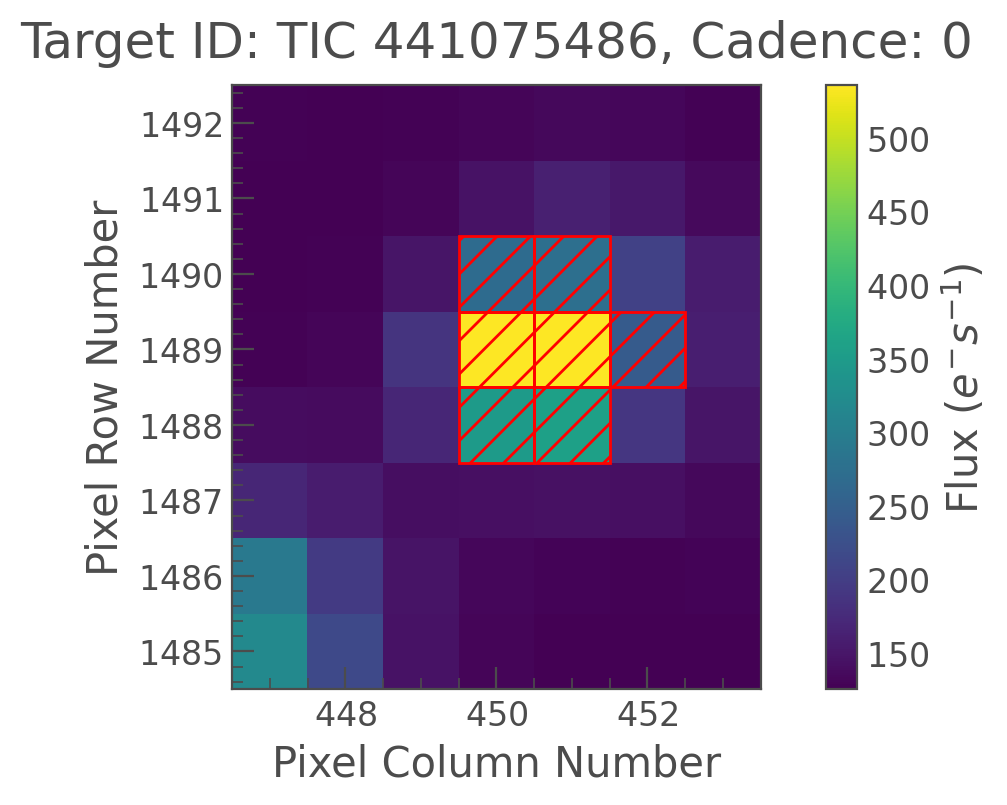

In [3]:
tpf.plot(aperture_mask=aper)

In [4]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

Let's take a look at the light curve.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

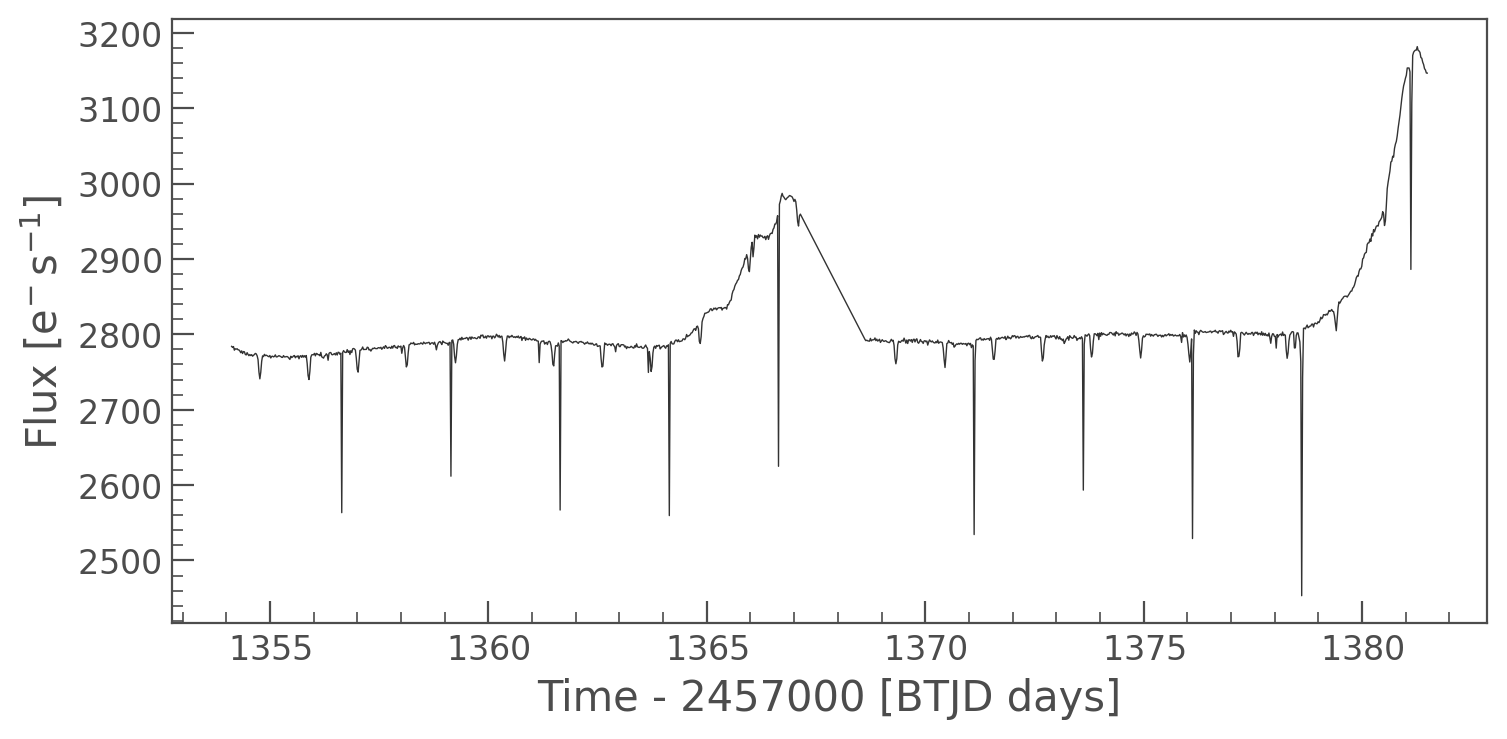

In [5]:
raw_lc.plot()

You can see a few things in this light curve
1. There is a planet transit
2. There is a periodic noise signal where the TESS pointing is bad (this is flagged in TESS quality flags)
3. You can see a long term trend from the sky background
4. You can see a little noise from the jitter, particularly around 1377 BTJD.

Let's correct this!! We can use `tess_backdrop`'s `TESSCutCorrector` function to do this. This functionality works exactly like `lightkurve`'s `RegressionCorrector` or `PLDCorrector`.

In [6]:
r = tbd.TESSCutCorrector(tpf, aperture_mask=aper)
corrected_lc = r.correct(npca_components=15, spline_timescale=1)

Before we look at the light curve, let's `diagnose` the corrector and see if it did what we expect.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

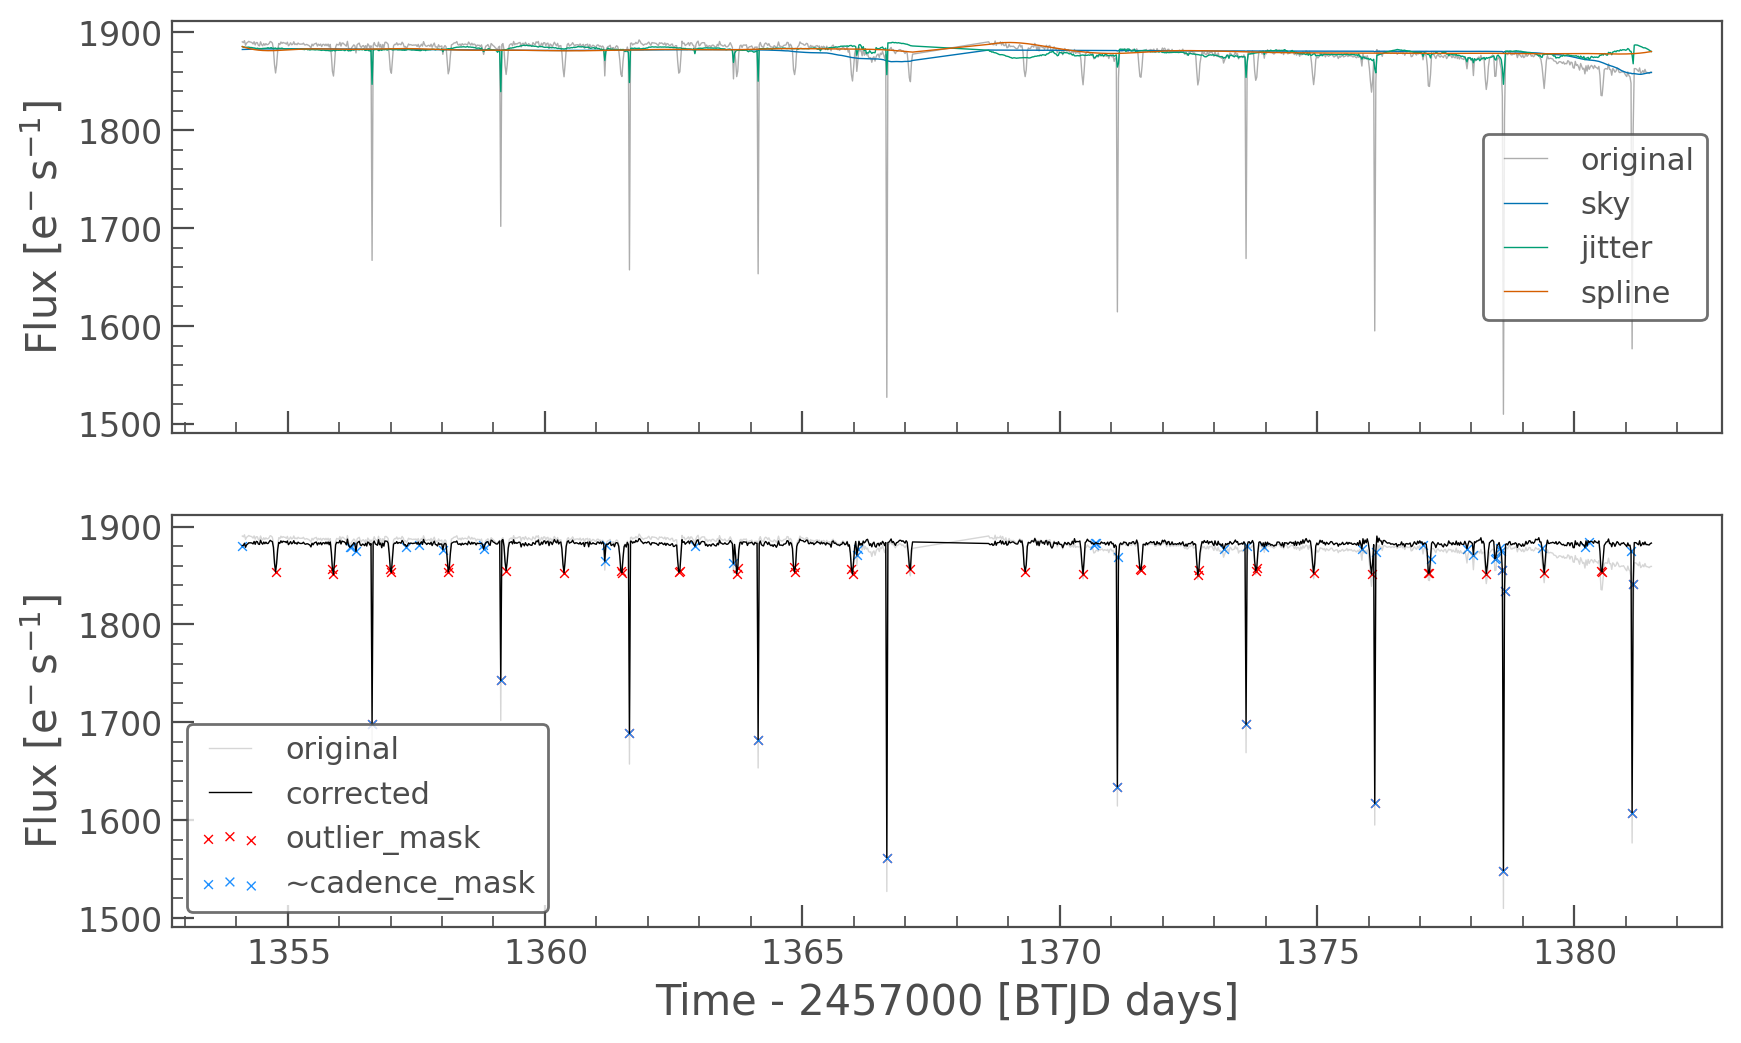

In [7]:
r.diagnose()

The corrector 
1. Automatically masked thed bad quality TESS data (blue points)
2. Automatically tried to mask the planet transits (you can tune this in the `correct` function with the `sigma` and `cadence_mask` keywords)
3. Fit three components; `sky`, `jitter` and `spline`. `sky` and `jitter` are built from `tess_backdrop`'s stored background solution. The `spline` is a flexible term to capture stellar/astrophysical variability. You can tune it in correct with the `spline_timescale` and `spline_degree` keywords.


Let's plot the light curve!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

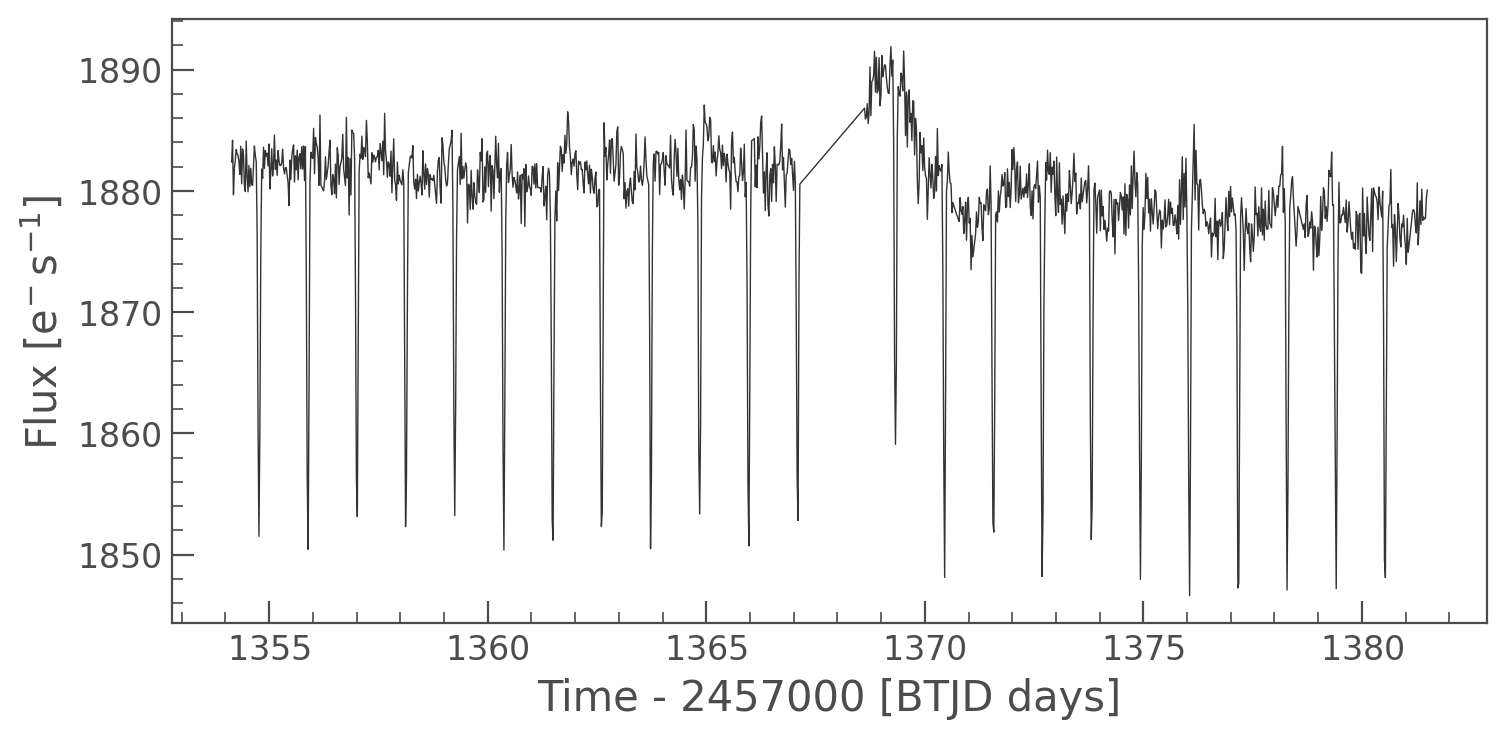

In [8]:
# Here we make a mask to get rid of the poor quality data for plotting purposes.
k = lk.utils.TessQualityFlags.create_quality_mask(corrected_lc.quality, 175)

corrected_lc[k].plot()

Looks great! So much better. Let's compare to the available pipeline products for this target.

In [9]:
plc = lk.search_lightcurve('TIC 441075486', sector=2)[1].download(quality_bitmask=None)

/Users/ch/Library/Caches/pypoetry/virtualenvs/tess-backdrop-I6bkZfRS-py3.9/lib/python3.9/site-packages/lightkurve/lightcurve.py:990: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(
/Users/ch/Library/Caches/pypoetry/virtualenvs/tess-backdrop-I6bkZfRS-py3.9/lib/python3.9/site-packages/lightkurve/lightcurve.py:990: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

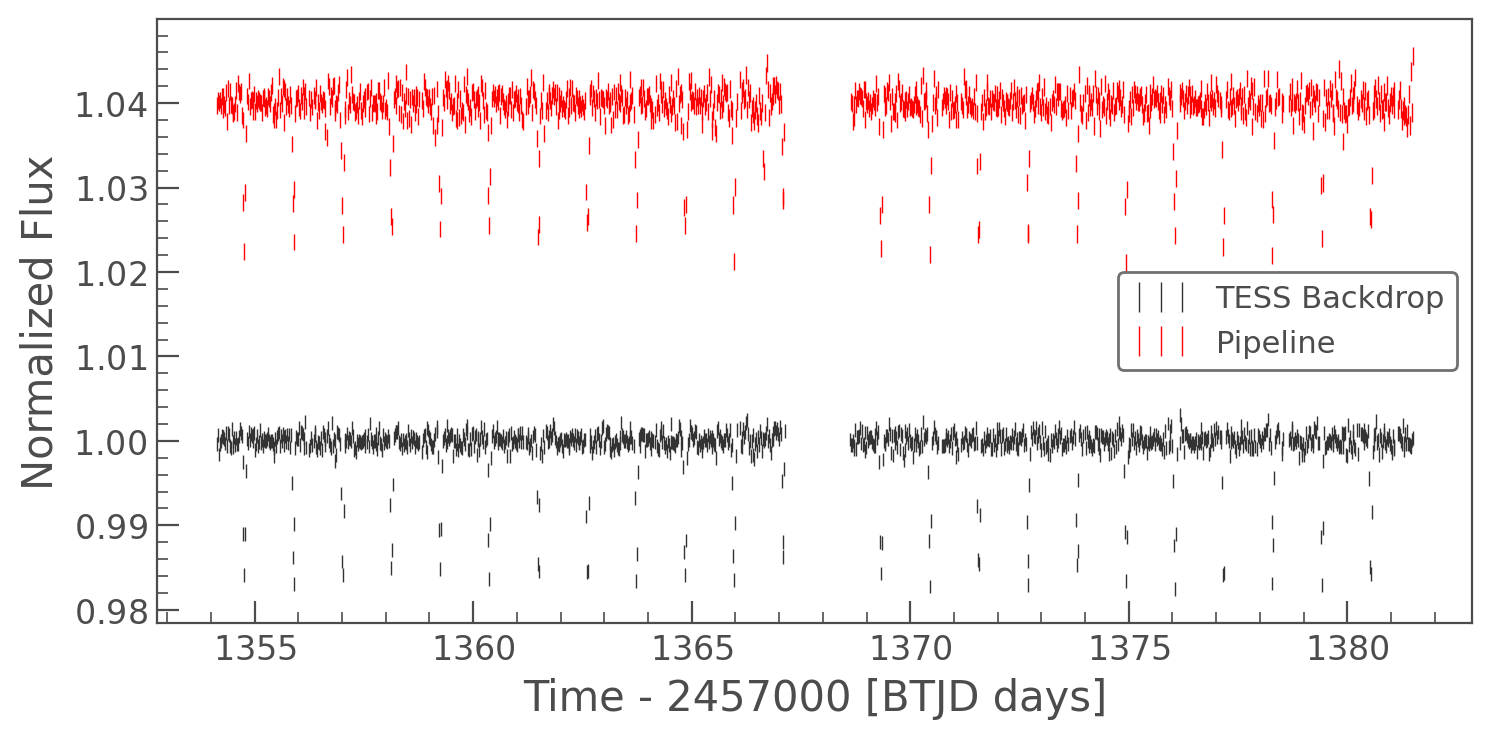

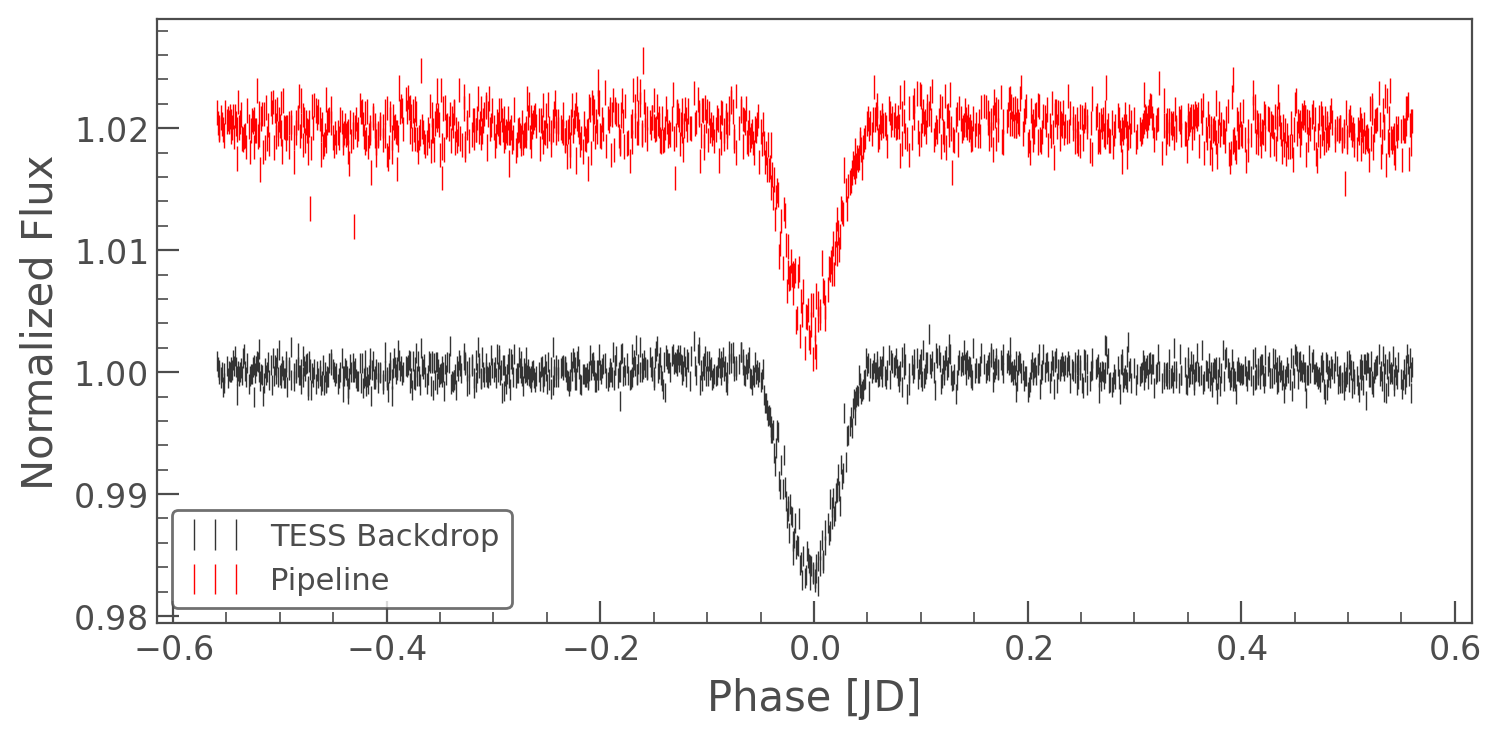

In [10]:
import numpy as np
# This is the period and t0 of a planet candidate in the data
p, t0 = 1.12026, 1354.77

# Here we make a quick mask to get rid of any serious outliers
f = corrected_lc.fold(p, t0).normalize()
fb = f.bin(p/100, aggregate_func=np.median)

# And now we plot the data
ax = corrected_lc.flatten(41, mask=~k)[k].normalize().errorbar(label='TESS Backdrop')
(plc.flatten(41, mask=~k)[k].remove_outliers(10).normalize() + 0.04).errorbar(ax=ax, c='r', label='Pipeline')

# and folded
ax = corrected_lc.flatten(41, mask=~k)[k].normalize().fold(p, t0).errorbar(label='TESS Backdrop')
(plc.flatten(41, mask=~k)[k].remove_outliers(10).normalize().fold(p, t0) + 0.02).errorbar(ax=ax, c='r', label='Pipeline')

Looks great! We're able to correct more of the jitter noise and get a really nice light curve with slightly better CDPP.

In [11]:
print('Pipeline CDPP: {}'.format(plc.estimate_cdpp()))
print('tess-backdrop CDPP: {}'.format(corrected_lc.estimate_cdpp()))

Pipeline CDPP: 1027.1829627336908 ppm
tess-backdrop CDPP: 663.5217637414905 ppm
